Try to generate room imprints with pre-defined templates and seeds

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import random
from grid import *
import cv2 as cv
import os

In [13]:
print(os.getcwd())

c:\Users\mehds\Documents\EPFL\MA4\Procedural_Building_Generation\ProceduralBuildingGeneration


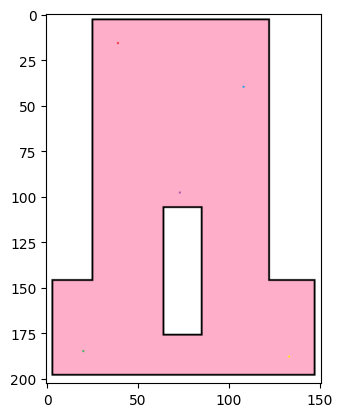

In [14]:
floorplans = []
data_dir = "data/pre_defined/"
for filename in os.listdir(data_dir):
    if filename.lower().endswith(('.png', 'jpeg')):
        filepath = os.path.join(data_dir, filename)
        floorplan = cv.imread(filepath)
        floorplan = cv.cvtColor(floorplan, cv.COLOR_BGR2RGB)
        plt.imshow(floorplan)
        floorplans.append(floorplan)

(684, 760, 3)


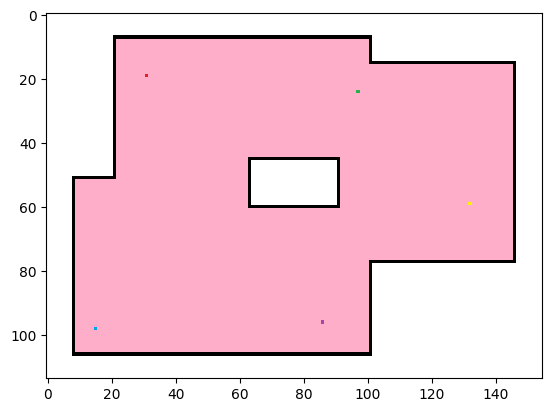

In [15]:
plt.imshow(floorplans[1])
print(floorplans[0].shape)

In [16]:
def image_to_int(floorplan):
    """
    Processes a floorplan image and converts it into a NumPy array with specific values.
    Also extracts the coordinates of seed pixels.
    Args:
        floorplan: Floorplan to be processed

    Returns:
        np.array: Processed NumPy array.
        list: List of seed coordinates in the format [(x1, y1, value1), (x2, y2, value2), ...].
    """
    color_to_value = {
        (0, 0, 0): 1,          # Walls (black)
        (255, 255, 255): 0,    # Outside (white)
        (255, 174, 201): 255,  # Inside (pink)
        (237, 28, 36): 128,      # Seed 1 (red)
        (0, 162, 232): 129,      # Seed 2 (blue)
        (34, 177, 76): 130,      # Seed 3 (green)
        (163, 73, 164): 132,    # Seed 4 (purple)
        (255, 127, 39): 136,    # Seed 5 (orange)
        (255, 242, 0): 144     # Seed 6 (yellow)
    }
    y_max, x_max, _ = floorplan.shape
    floorplan_int = np.zeros((y_max, x_max), dtype=np.uint8)
    seeds = []

    for y in range(y_max):
        for x in range(x_max):
            pixel = tuple(floorplan[y, x])
            if pixel in color_to_value:
                floorplan_int[y, x] = color_to_value[pixel]
                if floorplan_int[y, x] in [128, 129, 130, 132, 136, 144]:
                    seeds.append((x, y, floorplan_int[y, x]))
            else:
                raise ValueError(f"Unexpected color {pixel} at position ({x}, {y})")

    return floorplan_int, seeds

In [17]:
def plot_floorplan(output_array, seed_coordinates, save=False):
    """
    Plots the processed floorplan and highlights seed coordinates.

    Args:
        output_array (np.array): Processed floorplan array.
        seed_coordinates (list): List of seed coordinates in the format [(x1, y1, value1), ...].
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(output_array, cmap="viridis", vmin=0, vmax=255)
    plt.colorbar(label="Pixel Value")
    plt.title("Processed Floorplan")
    for seed in seed_coordinates:
        print(seed)
        x, y, value = seed
        plt.scatter(x, y, color="red", s=50, edgecolors="white", label=f"Seed {value}")
        plt.text(x, y, f"{value}", color="white", fontsize=12, ha="center", va="center")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if (save):
        filename = f"Floor_{seed_coordinates[0][0]}.png"  # Use the first seed's x-coordinate in the filename
        plt.savefig(filename, dpi=300, bbox_inches="tight")  # Save with high resolution and tight bounding box
    plt.show()
    plt.close()  # Close the figure to free up memory



In [18]:
floorplans_int, seeds = [], []
for floorplan in floorplans[1:]:
    floorplan_int, seed = image_to_int(floorplan)
    #plot_floorplan(floorplan_int, seed)
    floorplans_int.append(floorplan_int)
    seeds.extend([seed])

In [19]:
print(seeds[0][0])

(31, 19, 128)


(21, 16, 130)
(107, 16, 129)
(55, 44, 144)
(116, 57, 132)
(20, 86, 128)


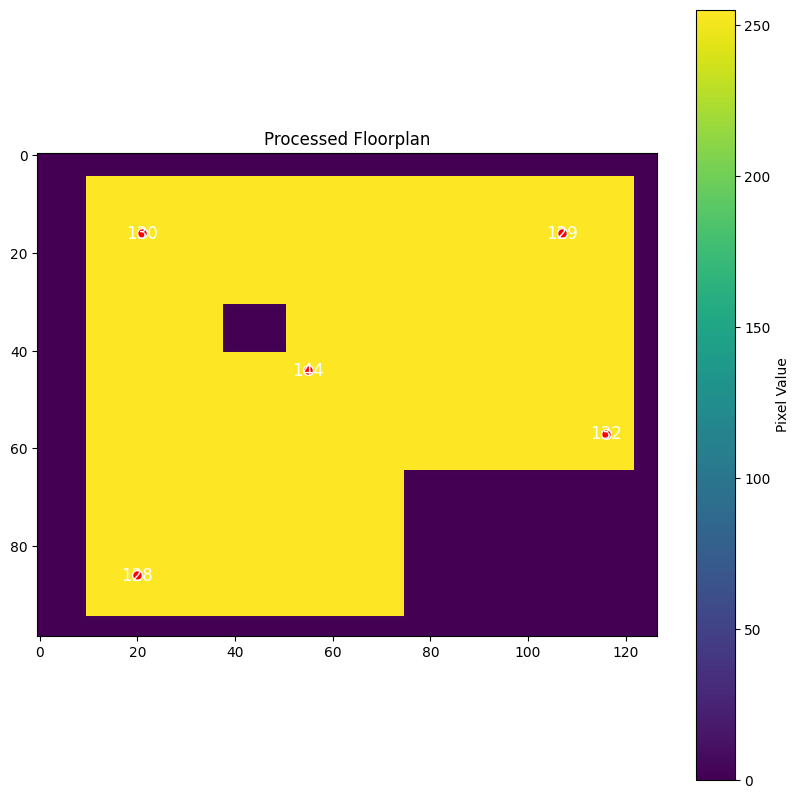

(99, 127)


In [20]:
plot_floorplan(floorplans_int[1], seeds[1])
print(floorplans_int[1].shape)

In [ ]:
from collections import deque

def region_growing_simultaneous(grid, seeds):
    """
    Grows seeds simultaneously by 1 pixel per round.
    Args:
        grid (np.array): Input floorplan grid.
        seeds (list): List of seed coordinates [(x1, y1, value1), ...].
        connectivity (int): 4 or 8 for 4-connected or 8-connected growth.
    Returns:
        np.array: Grid with grown regions.
    """
    # Create a copy of the grid to store the result
    result = grid.copy()
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1)          , (0, 1), 
                  (1, -1) ,  (1, 0), (1, 1)]  # 4-connected

    # Initialize a queue with all seeds
    queue = deque()
    for x, y, value in seeds:
        queue.append((y, x, value))  # Store (x, y, value) for each seed
        result[y, x] = value  # Mark the seed position in the result grid

    # Perform simultaneous region growing
    while queue:
        round_size = len(queue)# Process all pixels in the current round
        for _ in range(round_size):
            x, y, value = queue.popleft()
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                # Check if the neighbor is inside (255) and not already assigned
                if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1] and result[nx, ny] == 255:
                    has_adjacent_region = False # Check if the neighbor has any adjacent pixels from other regions
                    for ddy, ddx in directions: 
                        nny, nnx = ny + ddy, nx + ddx
                        if 0 <= nnx < grid.shape[0] and 0 <= nny < grid.shape[1]:
                            if result[nnx, nny] != 255 and (result[nnx, nny] != 1 and result[nnx, nny] != value):
                                has_adjacent_region = True
                                break
                    # If no adjacent regions, assign the value
                    if not has_adjacent_region:
                        result[nx, ny] = value  # Assign the seed's value
                        queue.append((nx, ny, value))  # Add to the queue for the next round
    return result


def fit_largest_rectangle(grid, room_number):
    """ 
    Fit largest rectangle in room with room cells.
    Returns the coordinates of the largest rectangle as (top, left, bottom, right).
    If no room is found, returns None.

    Algorithm is Leetcode's 85th one
    Solution and explanation here:https://algo.monster/liteproblems/85
    """
    if grid.size == 0:
        return None
    
    max_area = 0
    max_coords = (0, 0, 0, 0)
    rows, cols = grid.shape
    heights = [0] * cols  # Initialize heights array for histogram
    
    for row_idx in range(rows):
        for col in range(cols):
            if grid[row_idx][col] == room_number:
                heights[col] += 1
            else:
                heights[col] = 0
        
        # Find the largest rectangle in the current histogram using a stack
        stack = [-1]  # Initialize stack with -1 to help with boundary calculations
        for i in range(cols + 1):
            # Current height is heights[i] if within bounds, else 0 to trigger a flush
            current_height = heights[i] if i < cols else 0
            
            # Pop from stack while the current height is less than the stack's top
            while stack[-1] != -1 and current_height < heights[stack[-1]]:
                h = heights[stack.pop()]
                # Width is from the previous stack element to current index minus one
                w = i - stack[-1] - 1
                area = h * w
                # Update max_area and coordinates if this is the largest found so far
                if area > max_area:
                    max_area = area
                    left = stack[-1] + 1
                    right = i - 1
                    top = row_idx - h + 1
                    bottom = row_idx
                    max_coords = (top, left, bottom, right)
            
            stack.append(i)
    
    return max_coords if max_area > 0 else None

def build_wall(grid, a, b):
    """
    Builds a straight wall between points a and b on the grid.
    Walls can be either horizontal or vertical.
    """
    x_a, y_a = a
    x_b, y_b = b

    if not(x_a == x_b or y_a == y_b):
        raise ValueError(f"Wall is not straight")
    
    if y_a == y_b:
        for x in range(min(x_a, x_b), max(x_a, x_b) + 1):
            grid[x][y_a] = 18  # Mark as wall

    else: # Build vertical wall
        for y in range(min(y_a, y_b), max(y_a, y_b) + 1):
            grid[x_a][y] = 18  # Mark as wall

    return grid


def generate_mapping_rectangles(grid, rooms=(128, 129, 130, 132, 136, 144)):
    """
    Fills the largest rectangle in each room with the given value.
    """
    # Step 1: Find Corners

    corners_rooms = []
    corners_floor = mark_corners_floor(grid)
    corners_t = mark_corners_T(grid)

    for room in rooms:
        rect = fit_largest_rectangle(grid, room)
        if rect is None:
            continue  # Skip if no rectangle is found

        top, left, bottom, right = rect
        corners_rooms.append((top - 1, left - 1))  # Top-left corner
        corners_rooms.append((bottom + 1, left - 1))  # Bottom-left corner
        corners_rooms.append((top - 1, right + 1))  # Top-right corner
        corners_rooms.append((bottom + 1, right + 1))  # Bottom-right corner
    
    corners_all = list(set(corners_floor + corners_rooms + corners_t)) # Combine corners and remove duplicates

    # Step 2 Generate rectangles
    rectangles = gen_rect_corners(corners_all)

    for rect in rectangles:
        (x1, y1), (x2, y2) = rect
        grid = build_wall(grid, (x1, y1), (x2, y1))  # Top wall
        grid = build_wall(grid, (x1, y2), (x2, y2))  # Bottom wall
        grid = build_wall(grid, (x1, y1), (x1, y2))  # Left wall
        grid = build_wall(grid, (x2, y1), (x2, y2))  # Right wall

    return int_to_color(grid)

def gen_rect_corners(corners):
    """
    Generates rectangles using all neighboring corners on either axis.
    """
    final_rectangles = []

    # Group corners by their x and y coordinates
    x_groups = {}  # Key: y-coordinate, Value: list of x-coordinates
    y_groups = {}  # Key: x-coordinate, Value: list of y-coordinates

    for x, y in corners:
        if y not in x_groups:
            x_groups[y] = []
        x_groups[y].append(x)

        if x not in y_groups:
            y_groups[x] = []
        y_groups[x].append(y)

    # Sort the groups for easier processing
    for y in x_groups:
        x_groups[y].sort()
    for x in y_groups:
        y_groups[x].sort()

    # Generate rectangles using neighboring corners on the x-axis
    for y in x_groups:
        x_list = x_groups[y]
        for i in range(len(x_list) - 1):
            x1 = x_list[i]
            x2 = x_list[i + 1]
            final_rectangles.append(((x1, y), (x2, y)))  # Horizontal rectangle

    # Generate rectangles using neighboring corners on the y-axis
    for x in y_groups:
        y_list = y_groups[x]
        for i in range(len(y_list) - 1):
            y1 = y_list[i]
            y2 = y_list[i + 1]
            final_rectangles.append(((x, y1), (x, y2)))  # Vertical rectangle

    return final_rectangles

def mark_corners_floor(grid):
    """
    Marks corners of the floor map (walls and boundaries).
    """
    corners = []
    rows, cols = grid.shape
    for x in range(rows):
        for y in range(cols):
            if grid[x][y] == 1:  # Wall
                # Check if it's a corner
                if (x == 0 or x == rows - 1 or y == 0 or y == cols - 1) or (
                    (grid[x - 1][y] != 1 and grid[x][y - 1] != 1) or
                    (grid[x + 1][y] != 1 and grid[x][y - 1] != 1) or
                    (grid[x - 1][y] != 1 and grid[x][y + 1] != 1) or
                    (grid[x + 1][y] != 1 and grid[x][y + 1] != 1)):
                    corners.append((x, y))
    return corners

def mark_corners_T(grid, room_corners):
    """
    Detects T-corners in the grid and adds them to the list of corners.
    A T-corner is a room corner inside the floor that can be extended to form a T-shape.
    """
    rows, cols = grid.shape
    t_corners = []
    for x, y in room_corners:
        if 
    return t_corners

def int_to_color(result):
    reverse_mapping = {
        18: (40, 81, 81),       # Rectangle wall
        128: (237, 28, 36),      # Seed 1 (red)
        129: (0, 162, 232),      # Seed 2 (blue)
        130: (34, 177, 76),      # Seed 3 (green)
        132: (163, 73, 164),     # Seed 4 (purple)
        136: (255, 127, 39),     # Seed 5 (orange)
        144: (255, 242, 0)      # Seed 6 (yellow)
    }
    color_coded_grid = np.zeros((result.shape[0], result.shape[1], 3), dtype=np.uint8)
    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            value = result[y, x]
            if value in reverse_mapping:
                color_coded_grid[y, x] = reverse_mapping[value]
            elif value == 1:  # Walls
                color_coded_grid[y, x] = (0, 0, 0)  # Black
            elif value == 0:  # Outside
                color_coded_grid[y, x] = (255, 255, 255)  # White
            elif value == 255:  # Inside (unassigned)
                color_coded_grid[y, x] = (255, 192, 203)  # Pink

    return color_coded_grid

(99, 127)
4-Connected Result:
(21, 16, 130)
(107, 16, 129)
(55, 44, 144)
(116, 57, 132)
(20, 86, 128)


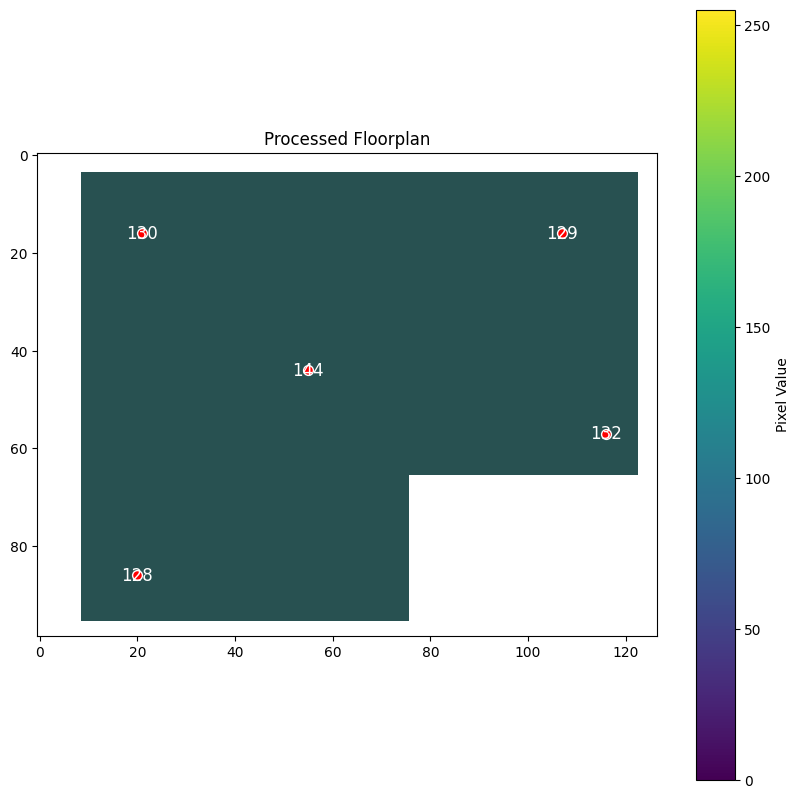

(132, 152)
4-Connected Result:
(131, 17, 128)
(35, 23, 144)
(45, 72, 130)
(90, 78, 132)
(124, 112, 129)


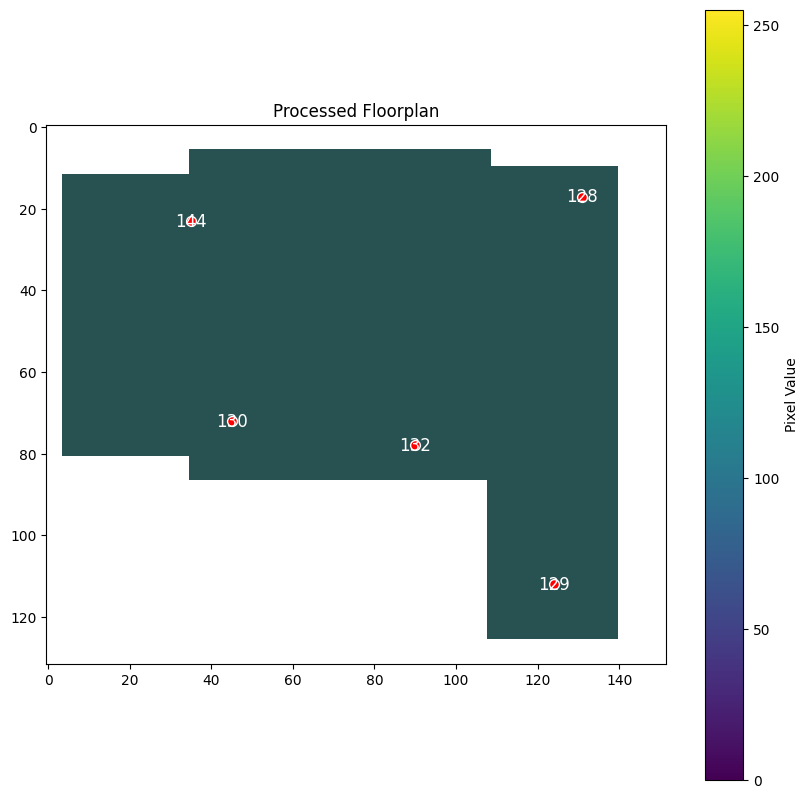

(137, 192)
4-Connected Result:
(96, 9, 136)
(20, 14, 144)
(176, 14, 129)
(98, 54, 130)
(16, 122, 128)
(183, 128, 132)


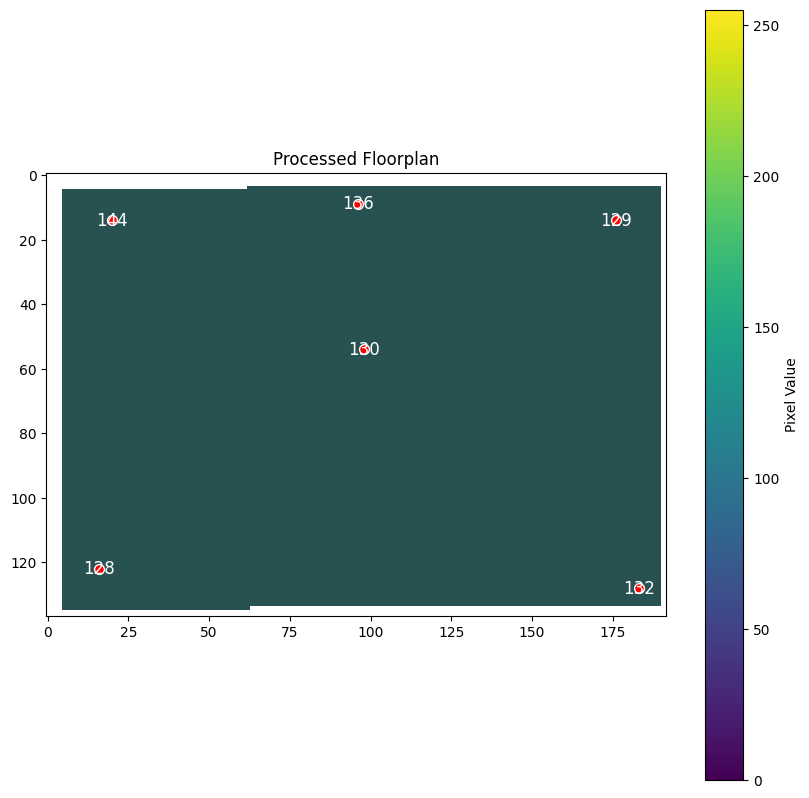

(120, 117)
4-Connected Result:
(106, 11, 130)
(16, 12, 128)
(55, 60, 132)
(18, 101, 144)
(103, 104, 129)


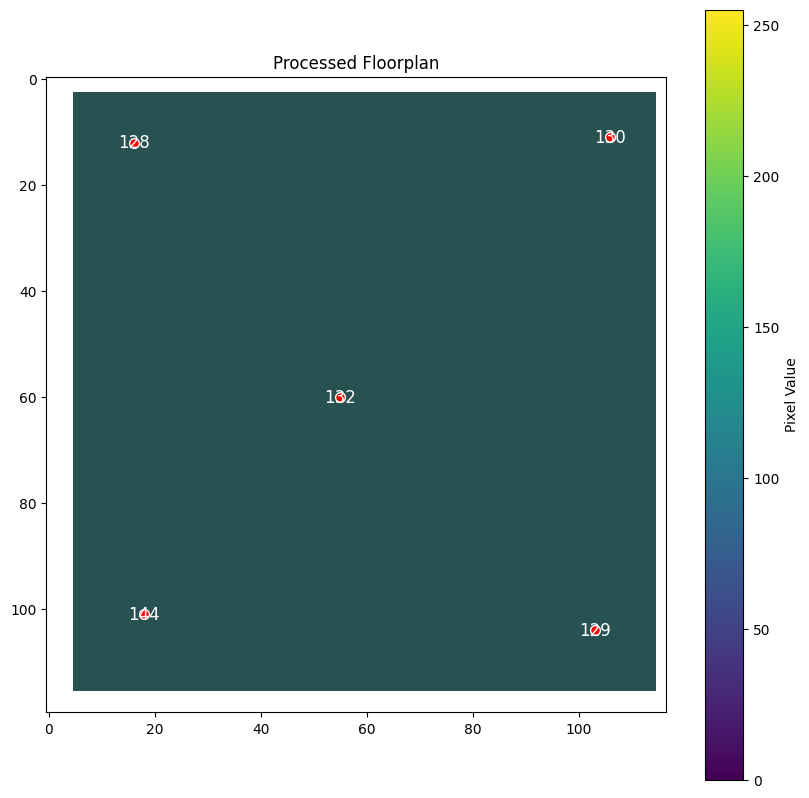

(175, 214)
4-Connected Result:
(116, 9, 132)
(12, 16, 130)
(197, 69, 129)
(70, 92, 144)
(18, 150, 128)
(137, 164, 136)


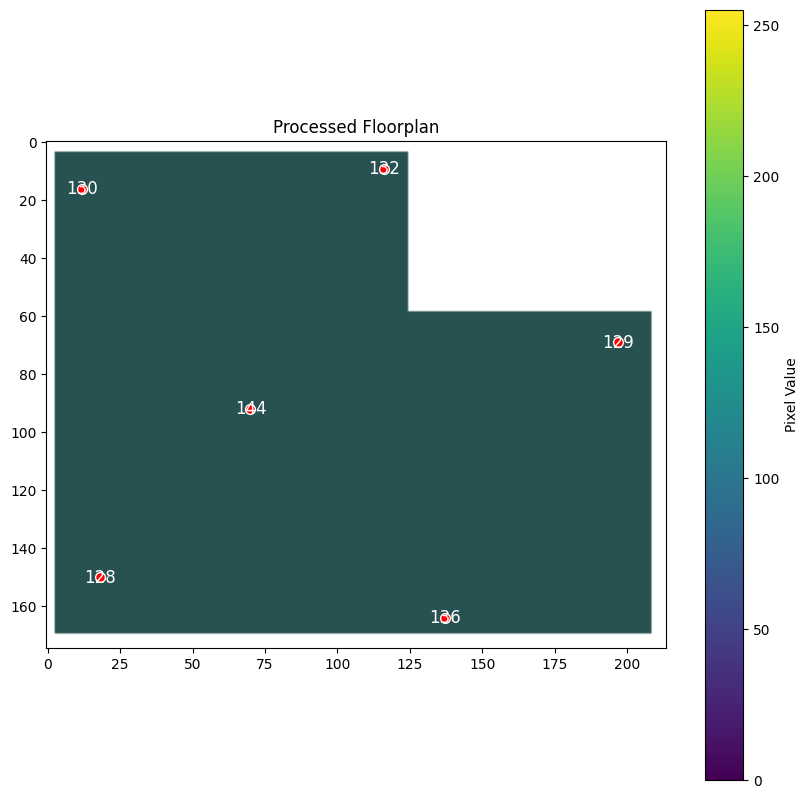

(72, 232)
4-Connected Result:
(167, 9, 130)
(65, 16, 132)
(14, 34, 128)
(112, 49, 144)
(218, 59, 129)


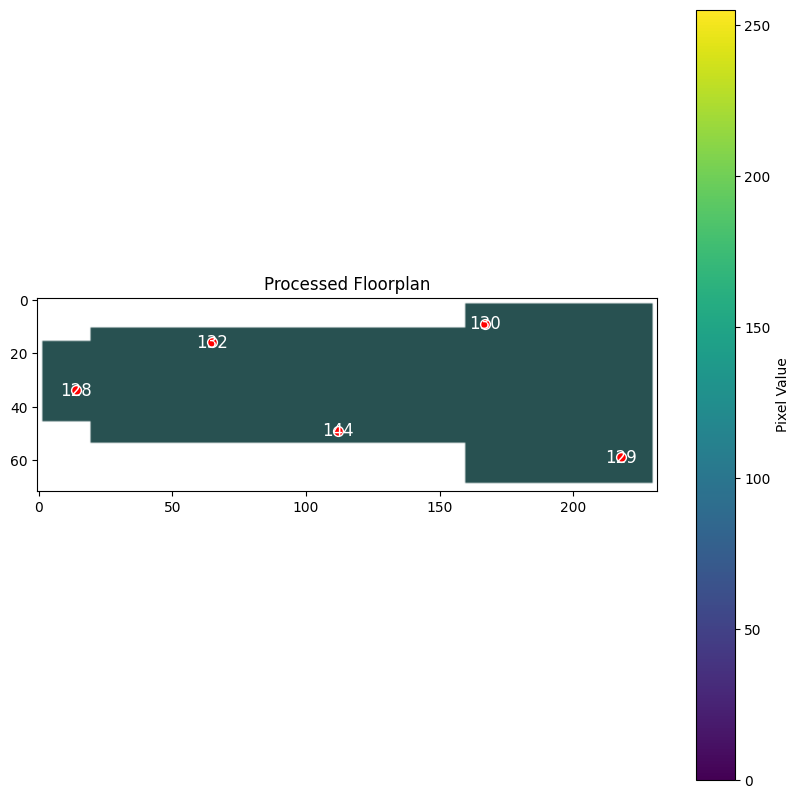

(222, 245)
4-Connected Result:
(93, 21, 128)
(21, 51, 132)
(94, 122, 144)
(13, 165, 130)
(232, 190, 129)
(85, 211, 136)


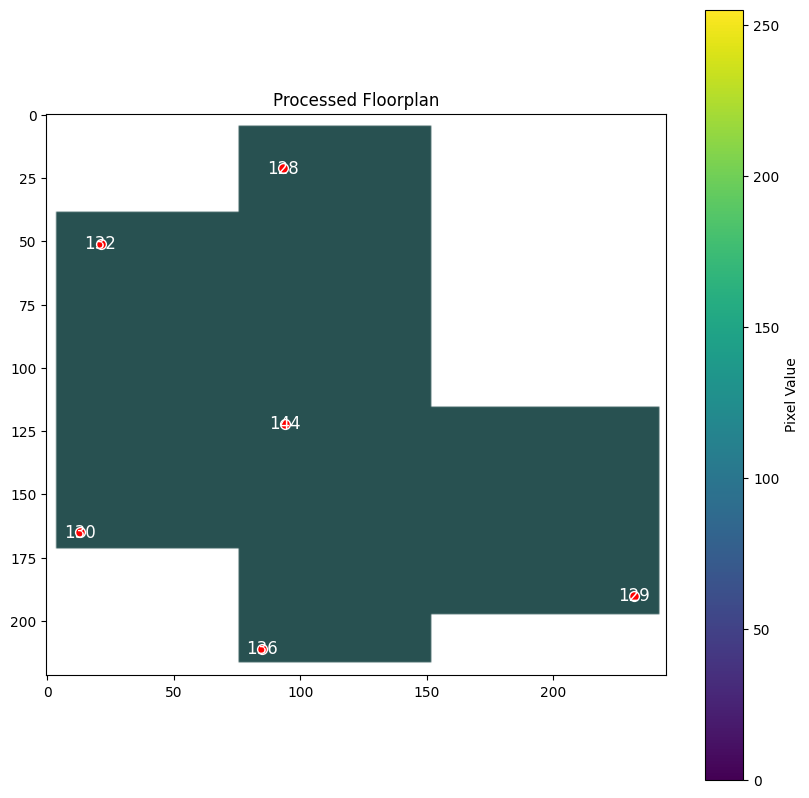

(158, 168)
4-Connected Result:
(155, 10, 130)
(14, 55, 128)
(122, 72, 132)
(70, 129, 144)
(148, 139, 129)


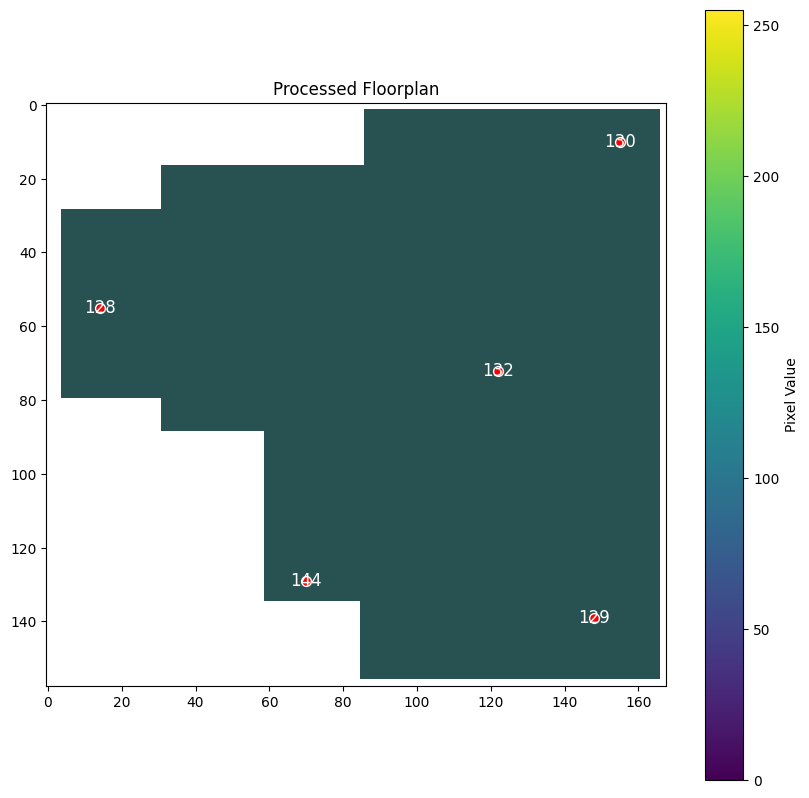

(203, 151)
4-Connected Result:
(39, 16, 128)
(108, 40, 129)
(73, 98, 132)
(20, 185, 130)
(133, 188, 144)


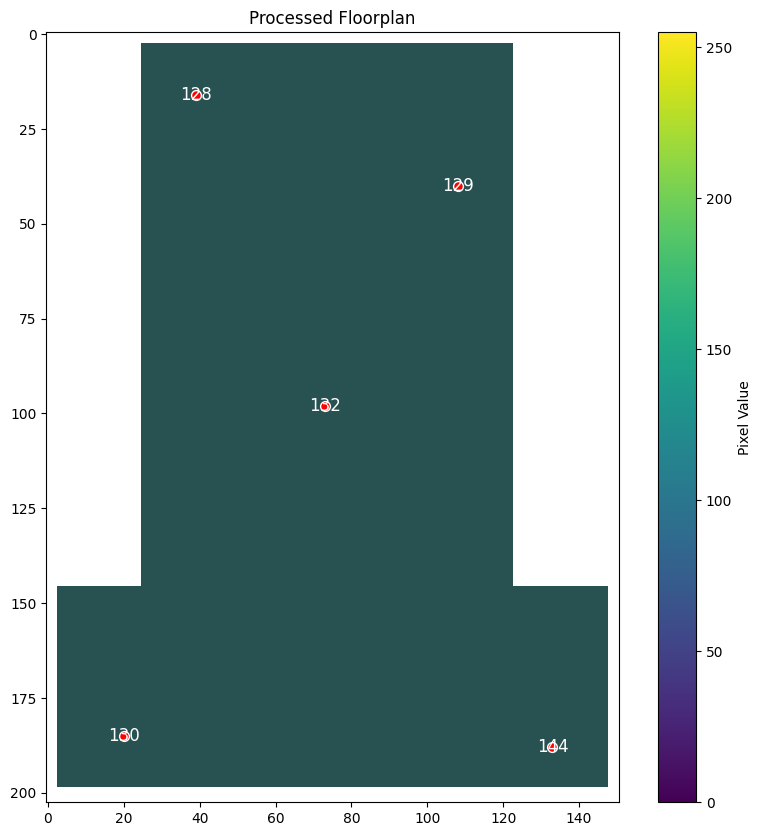

In [79]:
seeded_floorplans = []
np.set_printoptions(linewidth=np.inf, threshold=np.inf)

for floorplan, seed in zip(floorplans_int[1:], seeds[1:]):
    result = region_growing_simultaneous(floorplan, seed)
    print(result.shape)
    result_boxed = generate_mapping_rectangles(np.array(result))

    print("4-Connected Result:")
    plot_floorplan(result_boxed, seed)